# Steps

1. General dataset exploration
2. Basic data visualisation
3. Tokenize text data
4. Build autencoder and clustering layer
5. Visualize the cluster with Seaborn
6. Interactive scatterplot with Bokeh

# Load the Dataset and Validate 5 Samples

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import tensorflow as tf; 
print(tf.test.is_built_with_cuda())

True


In [2]:
INPUT_DIR_NETFLIX = "netflix_titles.csv"

df_netflix = pd.read_csv(INPUT_DIR_NETFLIX)
df_netflix.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
886,s887,TV Show,The Mystic River,Uzodinma Okpechi,"Jide Kosoko, Dele Odule, Lota Chukwu, Ben Toui...",NaN,"May 14, 2021",2020,TV-14,1 Season,"International TV Shows, TV Horror, TV Sci-Fi &...",As pregnant women vanish in a remote Nigerian ...
3843,s3844,TV Show,Away From Home,NaN,"Li Yongzhen, Zhuang Kebi, Zhang Shunyuan, Wang...",NaN,"May 8, 2019",2015,TV-PG,1 Season,"International TV Shows, TV Dramas",A high-achieving 11-year-old student embarks o...
7520,s7521,Movie,Mr. Woodcock,Craig Gillespie,"Billy Bob Thornton, Seann William Scott, Ethan...",United States,"September 1, 2019",2007,PG-13,88 min,Comedies,When a self-help author learns that his mother...
3661,s3662,Movie,Bogda,Nisheeta Keni,"Suhas Joshi, Mrunmayee Deshpande, Rohit Kokate...",India,"July 16, 2019",2018,TV-PG,161 min,"Dramas, International Movies",An aspiring dancer accompanies her terminally ...
7322,s7323,Movie,Lizzie Borden Took an Ax,Nick Gomez,"Christina Ricci, Clea DuVall, Gregg Henry, Ste...",United States,"July 25, 2016",2014,TV-14,87 min,Thrillers,This made-for-TV drama chronicles the scandal ...


# Data Cleansing and Fetching Movie Data

1. Remove duplications
2. Replace missing director data with 'no data'
3. Drop NA records 

In [4]:
df_netflix['director'].replace(np.nan, 'No Data',inplace  = True)

# Drops

df_netflix.dropna(inplace=True)

# Drop Duplicates

df_netflix.drop_duplicates(inplace= True)

df_movies_netflix = df_netflix.loc[df_netflix['type'] == 'Movie']

# verify dataframe
print(df_movies_netflix.isnull().sum())
print(df_movies_netflix.info())

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 7 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       5277 non-null   object
 1   type          5277 non-null   object
 2   title         5277 non-null   object
 3   director      5277 non-null   object
 4   cast          5277 non-null   object
 5   country       5277 non-null   object
 6   date_added    5277 non-null   object
 7   release_year  5277 non-null   int64 
 8   rating        5277 non-null   object
 9   duration      5277 non-null   object
 10  listed_in     5277 non-null   object
 11  description   5277 non-null   object
dtypes: int64(1), object(11)
memory usage: 535.9+ KB
None


# Feature Selection for Clustering

- Lets start with just the description.

- Preprocess and tokenize the description


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

In [6]:
text_content = df_movies_netflix['description']
vector = TfidfVectorizer(max_df = 0.4,           # drop words that occur more than max_df %
                         stop_words = 'english', # remove stop words
                         lowercase = True,       # everything to lowercase
                         use_idf = True,
                         norm = u'l2',
                         smooth_idf = True       # prevent divide by zero errors
                         )

tfidf = vector.fit_transform(text_content)

In [7]:
k = 5
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centres = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vector.get_feature_names()

request_transform = vector.transform(df_movies_netflix['description'])
df_movies_netflix['cluster'] = kmeans.predict(request_transform)
df_movies_netflix['cluster'].value_counts()

<ipython-input-7-0b88812b299f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_netflix['cluster'] = kmeans.predict(request_transform)


3    4603
0     504
1     116
4      53
2       1
Name: cluster, dtype: int64

## Classification

### Preprocessing

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_movies_netflix['description'].values)
sequences = tokenizer.texts_to_sequences(df_movies_netflix['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 15155 unique tokens.


In [10]:
categorized_clustered_labels = to_categorical(df_movies_netflix['cluster'], num_classes=5)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X , categorized_clustered_labels, test_size=0.25, random_state=42)

In [26]:
epochs = 10
emb_dim = 128
batch_size = 64

In [27]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [29]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',recall_m, precision_m,f1_m])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((3957, 130), (3957, 5), (1320, 130), (1320, 5))
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 130, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,073,733
Trainable params: 1,073,733
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
50/50 [==============================] - 18s 

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

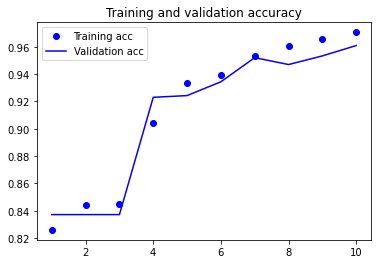

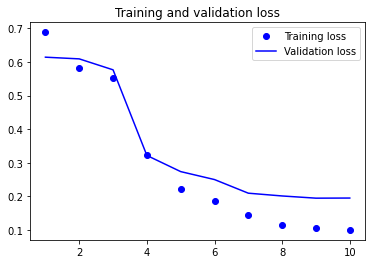

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()